<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Analog2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dtw-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 580 kB 4.2 MB/s 


In [2]:
pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 177 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=d8666032d202b5e3b2ddfa2557b74c7d5254af8a4c2716735c2d999b7dffa61e
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz


In [3]:
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, Lasso, Ridge, BayesianRidge, LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from math import sqrt
from dtw import *
from scipy import stats
%matplotlib inline

sns.set_theme(style="white")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'

df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()
serie = StandardScaler().fit_transform(serie)
serie = serie.ravel()  ## Con esto quitamos el bracket o corchete en cada uno de los elementos del arreglo

In [5]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [6]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-"; MAGE="FF00FF";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='fig_t16_serie.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [7]:
## Preparamos la información para graficar la importancia y las posiciones en Random Forest Regressor
def print_importances(model_,labels_,namefile_):
    i=0
    labels = [str(x) for x in labels_]
    labels_importances = []
    for feature in model_.feature_importances_:
        labels_importances.append((feature,labels[i]))
        i=i+1   
    labels_importances.sort(key=lambda tup: tup[0], reverse=False)
    importances = []
    labels      = []
    for tup in labels_importances:
        importances.append(tup[0])
        labels.append(tup[1])
    fig, ax = plt.subplots()
    y_pos = np.arange(len(importances))
    ax.set_yticks(ticks=y_pos)
    ax.barh(labels, importances, align='center',color=CYAN)
    ax.invert_yaxis()
    ax.set_xlabel('Importancia', color=NARA, fontsize='large')
    ax.set_ylabel('Variable', color=NARA, fontsize='large')
    ax.set_title( 'Importancia de las variables del bosque aleatorio', color=NARA, fontsize='large')    
    plt.tick_params(colors = NARA, which='both')
    ax.spines['bottom'].set_color(NARA)
    ax.spines['top'   ].set_color(NARA) 
    ax.spines['right' ].set_color(NARA)
    ax.spines['left'  ].set_color(NARA)
    plt.savefig(namefile_, transparent=True)   
    plt.show()

In [8]:
def OLSstep(X, Y, X_2, pi_step_=0.001,verbose_=False):
    model   = sm.OLS(Y, X)
    results = model.fit()
    prediction_Y2 = results.predict(X_2)

    ## Ordenamos los valores 'pi' y se selecciona el más grande.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
    (i, pi) = pvalues[0]  

    while pi > pi:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2)   
        if verbose_==True:
            print('Retiramos regresor ---> X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## Ordenamos los valores 'pi' y se selecciona el más grande
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
        (i, pi) = pvalues[0]
        #prediction   = results.predict(X)   ## Ajuste
        prediction_Y2 = results.predict(X_2) ## Pronóstico
    if len(prediction_Y2) == 0:      
        if verbose_==True:
            print('>>> Warning, no variable was significant in the regression.')
        model   = sm.OLS(Y, X)
        results = model.fit()
        prediction_Y2 = results.predict(X_2)
        
    if verbose_==True:
        print(results.summary())
    return prediction_Y2   

In [9]:
def RF(X, Y, X_2,labels_,typedist_,verbose_=False):
    model         = RandomForestRegressor(random_state=42)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    if verbose_==True:
        print_importances(model_=model,labels_=labels_,namefile_='fig_t16_importance_'+typedist_+'_'+'RF')
        print('Parámetros utilizados RF')
        print("bootstrap:         {}".format(model.bootstrap))
        print("n_estimators:      {}".format(model.n_estimators))
        print("max_features:      {}".format(model.max_features))
        print("max_depth:         {}".format(model.max_depth))
        print("min_samples_leaf:  {}".format(model.min_samples_leaf))
        print("min_samples_split: {}".format(model.min_samples_split))
    return prediction_Y2   

In [10]:
def AutoRF(X, Y, X_2,labels_,typedist_,verbose_=False):
## https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    #nestlist = []
    #for i in range(10, 320, 50):
    #    nestlist.append(i)
    #param_grid = { 
    #'bootstrap': [True, False],
    #'n_estimators': nestlist,
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #'min_samples_leaf': [1, 2, 4],
    #'min_samples_split': [2, 5, 10],}
    nestlist = []
    for i in range(10, 320, 50):
        nestlist.append(i)
    param_grid = { 
        'bootstrap': [True, False],
        'n_estimators': nestlist,
        'max_features': ['auto', 'sqrt',],
        'max_depth' : [10, 20, None]}

    model = RandomForestRegressor(random_state=42)
    clf   = GridSearchCV(estimator=model, param_grid=param_grid, cv=5).fit(X, Y)
    model         = clf.best_estimator_
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)

    if verbose_==True:
        print_importances(model_=model,labels_=labels_,namefile_='fig_t16_importance_'+typedist_+'_'+'AutoRF')
        print('Parameters used')
        print("bootstrap:         {}".format(model.bootstrap))
        print("n_estimators:      {}".format(model.n_estimators))
        print("max_features:      {}".format(model.max_features))
        print("max_depth:         {}".format(model.max_depth))
        print("min_samples_leaf:  {}".format(model.min_samples_leaf))
        print("min_samples_split: {}".format(model.min_samples_split))        
    return prediction_Y2   

In [11]:
def Boosting(X, Y, X_2,typedist_,verbose_=False):
    model         = GradientBoostingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 

In [12]:
def Bagging(X, Y, X_2,typedist_,verbose_=False):
    model         = BaggingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [13]:
def AdaBoost(X, Y, X_2,typedist_,verbose_=False):
    model         = AdaBoostRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 

In [14]:
def LinearReg(X, Y, X_2,typedist_,verbose_=False):
    model         = LinearRegression()
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [15]:
def BayesRidge(X, Y, X_2,typedist_,verbose_=False):
    model         = BayesianRidge(compute_score=True)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2) 
    return prediction_Y2   

In [16]:
def LassoReg(X, Y, X_2,typedist_,verbose_=True):
    model         = Lasso(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2  

In [17]:
def RidgeReg(X, Y, X_2,typedist_,verbose_=False):
    model         = Ridge(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [18]:
def PLS(X, Y, X_2,n_components,typedist_,verbose_=False):
    model         = PLSRegression(n_components=n_components)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2

In [19]:
def PCR(X, Y, X_2,n_components,typedist_,verbose_=False):
## https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
    model         = make_pipeline(PCA(n_components=n_components), LinearRegression())
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [20]:
def VotingEnsemble(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    gb  = GradientBoostingRegressor(random_state=42)
    rf  = RandomForestRegressor(random_state=42)
    br  = BaggingRegressor(random_state=42)
    ab  = AdaBoostRegressor(random_state=42)
    gb.fit(X, Y)
    rf.fit(X, Y)
    br.fit(X, Y)
    ab.fit(X, Y)
    voting = VotingRegressor([("gb",gb), ("rf",rf), ("br",br), ("ab",ab)]) #
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    if verbose_ == True:
        predgb  = gb.predict(X_2)
        predrf  = rf.predict(X_2)
        predbr  = br.predict(X_2)  
        predab  = ab.predict(X_2) 
        ## https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.plot.html Markers, Line styles ,Colors
        fig, ax = plt.subplots(figsize=(19,10))
        plt.plot(predgb,  "md" , label="GradientBoostingRegressor") ## go- rs 
        plt.plot(predrf,  "b^" , label="RandomForestRegressor")
        plt.plot(predbr,  "go-", label="BaggingRegressor")
        plt.plot(predab,  "kD" , label="AdaBoostRegressor")
        plt.plot(prediction_Y2, "r*", ms=10, label="VotingEnsemble")
        plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
        plt.ylabel("demanda estandarizada", color=NARA, fontsize='large')
        plt.xlabel("training samples", color=NARA, fontsize='large')
        plt.legend(loc="best")
        plt.title("Pronósticos de ensambles y su promedio", color=NARA, fontsize='large')
        plt.tick_params(colors = NARA, which='both')
        ax.spines['bottom'].set_color(NARA)
        ax.spines['top'   ].set_color(NARA) 
        ax.spines['right' ].set_color(NARA)
        ax.spines['left'  ].set_color(NARA)
        plt.savefig("fig_t16_VotingEnsemble", transparent=True) 
        plt.show()
    return prediction_Y2   

In [21]:
def VotingLinear(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    pl = PLSRegression(n_components=1)
    lr = LinearRegression()
    ri = Ridge(alpha=0.1)
    la = Lasso(alpha=0.1)    
    pc = make_pipeline(PCA(n_components=1), LinearRegression())
    pl.fit(X, Y)
    lr.fit(X, Y)
    ri.fit(X, Y)
    la.fit(X, Y)
    pc.fit(X, Y)
    voting = VotingRegressor([("lr",lr),("ri",ri),("la",la),("pc",pc)]) #,("pl",pl)
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    if verbose_ == True:
        predpl = pl.predict(X_2)
        predlr = lr.predict(X_2)
        predri = ri.predict(X_2)
        predla = la.predict(X_2)
        predpc = pc.predict(X_2)
        ## https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.plot.html Markers, Line styles ,Colors
        fig, ax = plt.subplots(figsize=(17,9))
        plt.plot(predpl,  "md" , label="PLSRegression")
        plt.plot(predlr,  "b^" , label="LinearRegression")
        plt.plot(predri,  "go-", label="Ridge")
        plt.plot(predla,  "ys" , label="Lasso")
        plt.plot(predpc,  "cs" , label="PCR")
        plt.plot(prediction_Y2, "r*", ms=10, label="VotingLinear")
        plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
        plt.ylabel("demanda estandarizada", color=NARA, fontsize='large')
        plt.xlabel("training samples", color=NARA, fontsize='large')
        plt.legend(loc="best")
        plt.title("Pronósticos lineales y su promedio", color=NARA, fontsize='large')
        plt.tick_params(colors = NARA, which='both')
        ax.spines['bottom'].set_color(NARA)
        ax.spines['top'   ].set_color(NARA) 
        ax.spines['right' ].set_color(NARA)
        ax.spines['left'  ].set_color(NARA)
        plt.savefig("fig_t16_VotingLinear", transparent=True) 
        plt.show()
    return prediction_Y2   

In [22]:
## Calcula distancia euclidiana
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [23]:
def analogo_knn(serie,vsele,k=10,tol=0.8,n_components=3,typedist='pearson',typereg='OLS',verbose=False):    
#    vsele      : Tamanio de la ventana de selección
#    k          : Número de vecinos a buscar k
#    tol        : Tolerancia de tamaño de ventanas para seleccion de vecinos
#    typedist   : medida de distancia, 'dtw' o 'euclidian' o 'pearson'

    t_o = time.time()
    n = len(serie) ## longitud total de la serie

    ## PASO 1: Selección de las ventanas de mayor correlación.

    ## Calculamos la distancia entre todos los vecinos.
    distances = []
    Y = serie[n-vsele:n]           ## últimos datos
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'euclidian':
            dist = euclidean(Y,serie[i:i+vsele])
        else:
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        if dist > 0:
            distances.append((i, dist))
        
    ## Calculamos el vecindario por distancia de menor a mayor y se guardan las posiciones.
    if typedist == 'pearson':
        ## En caso de pearson se ordena al revés, nos interesan los mayor correlación.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        ## En caso de pearson se ordena al revés, nos interesan los de menor distancia.
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## Calculamos los k vecinos mas cercanos y guardamos las posiciones.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+vsele])
            neighbors2.append(serie[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## si ya teniamos una posición en la lista que pase la tolerancia, ya no la guardamos 
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## Guarda nuevo vecino
                positions.append(pos)   
                neighbors.append(serie[pos:pos+vsele])
                neighbors2.append(serie[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## posición de los k vecinos mas cercanos

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selección con KNN:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

    ## PASO 2: Regresión entre los vecinos mas cercanos 'X' y la última ventana 'Y'

    ## Definimos nuestros regresores   
    X   = (neighbors.T).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()
    prediction_Y2 = []

    ## -- Random forest regression --
    if typereg == 'RF':
        prediction_Y2 = RF(X,Y,X_2,labels_=positions,typedist_=typedist,verbose_=verbose)

    ## -- OLS with Stepwise --
    if typereg == 'OLSstep':
        prediction_Y2 = OLSstep(X,Y,X_2, pi_step_=0.001,verbose_=verbose)

    ## -- Gradiant boosting regression --
    if typereg == 'Boosting':
        prediction_Y2 = Boosting(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Bagging regression --
    if typereg == 'Bagging':
        prediction_Y2 = Bagging(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Linear regression --
    if typereg == 'LinearReg':
        prediction_Y2 = LinearReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ada boosting --
    if typereg == 'AdaBoost':
        prediction_Y2 = AdaBoost(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Bayesian Ridge --
    if typereg == 'BayesRidge':
        prediction_Y2 = BayesRidge(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Lasso regression --
    if typereg == 'LassoReg':
        prediction_Y2 = LassoReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ridge regression --
    if typereg == 'RidgeReg':
        prediction_Y2 = RidgeReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)

    ## -- PLS Regression --
    if typereg == 'PLS':
        prediction_Y2 = PLS(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- PCA Regression --
    if typereg == 'PCR':
        prediction_Y2 = PCR(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- Voting regression with ensemble models -- 
    if typereg == 'VotingEnsemble':
        prediction_Y2 = VotingEnsemble(X,Y,X_2,verbose_=verbose)

    ## -- Voting regression with linear model -- 
    if typereg == 'VotingLinear':
        prediction_Y2 = VotingLinear(X,Y,X_2,verbose_=verbose)
        
    ## -- Random forrest regression with GridSearchCV--
    if typereg == 'AutoRF':
        prediction_Y2 = AutoRF(X, Y, X_2,labels_=positions,typedist_=typedist,verbose_=verbose)        

    if verbose==True:
        print_serie2(neighbors2,prediction_Y2, 'Pronóstico - ' + typedist+' - ' + typereg ,'Demanda','Tiempo',8,5,'fig_t16_Y2_'+typedist+'_'+typereg)

    t_reg = time.time() - t_sel - t_o
    if typedist=='pearson':
      t_sel =2.2038
    if typedist=='euclidian':
      t_sel =23.4583

    return prediction_Y2, t_sel, t_reg

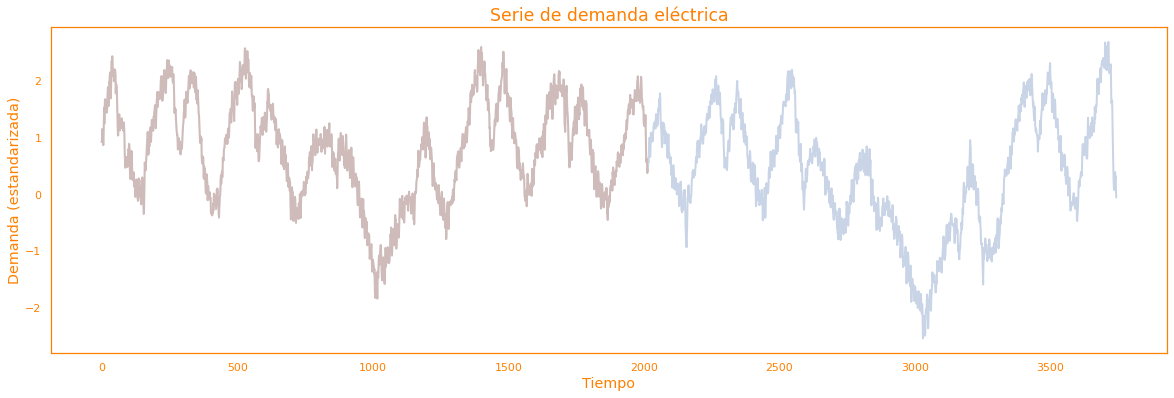

In [24]:
## ... (time serie) ... window.window.window.window.window.window.window.window.window.window.window.
##                                           |                                               |       |
##                                           |                                               |       |
##                                           |<------------------ vsele -------------------->|<vpred>|
##                                                       (selection and regression)        (prediction)
##                                                                                                 
##|<---------------------------------------- train ----------------------------------------->| <test>|

## Parámetros del método Análogo
periods       = 288        ## Número de periodos en una ventana
periods_sele  = 7          ## Número de ventanas de selección
periods_pred  = 6         ## Número de ventanas de pronóstico

vsele = periods * periods_sele ## Número de periodos para selección
vpred = periods * periods_pred ## Número de periodos para pronóstico

k   = 6   ## k:   número de vecinos mas cercanos
tol = 0.8 ## tol: porcentaje de tolerancia de cercania entre ventanas

## Dibujamos la ventana de histórico y los datos de prueba  
series = []; vacia = []; n = 2
series.append(serie[len(serie)-n*vsele : len(serie)-vsele+vpred])
series.append(serie[len(serie)-n*vsele : len(serie)-vsele])
print_serie2(serie_=series,prototipo_=vacia , title_='Serie de demanda eléctrica', ytitle_='Demanda (estandarizada)',xtitle_='Tiempo', sizex_=20, sizey_=6, namefile_='fig_t15_demanda')

## Definimos la ventana de prueba y entrenamiento
X_train = serie[0 : len(serie) - vpred]
y_test  = serie[len(serie) - vpred : len(serie)]

## Guardamos todos los resultados aquí
dferror = pd.DataFrame(columns=['distance','regression','MAE','MAPE','timesel','timereg'])

## Bandera que activa todos los pronósticos
debug  = 0
active = 0

In [28]:
distances = ['pearson', 'euclidian']
methods = ['RF', 'OLSstep', 'Boosting', 'Bagging', 'LinearReg', 'AdaBoost', 'LassoReg', 'RidgeReg', 'PLS', 'PCR', 'VotingEnsemble', 'VotingLinear'] # AutoRF, 'BayesRidge'
preds = []
for d in distances:
  for m in methods:
    print(d, m)
    pred_, t_sel_, t_reg_ = analogo_knn(X_train, vsele=vsele, k=k, tol=tol, typedist=d, typereg=m, verbose=False)
    preds.append({
        'distance' : d,
        'method' : m,
        'y_cap' : pred_
    })
    mae_  = mean_absolute_error(y_test, pred_[0:vpred])
    mape_ = mean_absolute_percentage_error(y_test,pred_[0:vpred])
    dferror.loc[dferror.shape[0]] = [d, m, mae_, mape_,t_sel_,t_reg_]
preds = pd.DataFrame(preds)
display(dferror)
display(preds)

pearson RF
pearson OLSstep
pearson Boosting
pearson Bagging
pearson LinearReg
pearson AdaBoost
pearson LassoReg
pearson RidgeReg
pearson PLS
pearson PCR
pearson VotingEnsemble
pearson VotingLinear
euclidian RF
euclidian OLSstep
euclidian Boosting
euclidian Bagging
euclidian LinearReg
euclidian AdaBoost
euclidian LassoReg
euclidian RidgeReg
euclidian PLS
euclidian PCR
euclidian VotingEnsemble
euclidian VotingLinear


,distance,regression,MAE,MAPE,timesel,timereg
0,pearson,RF,0.607161,2.995270,2.2038,1.822061
1,pearson,OLSstep,0.566529,4.664495,2.2038,0.047823
2,pearson,Boosting,0.650646,4.545101,2.2038,0.664064
3,pearson,Bagging,0.623723,4.324531,2.2038,0.093627
4,pearson,LinearReg,0.709961,5.086081,2.2038,0.036437
5,pearson,AdaBoost,0.634108,7.010996,2.2038,0.211125
6,pearson,BayesRidge,0.710178,5.104227,2.2038,0.013979
7,pearson,LassoReg,0.582797,3.676417,2.2038,0.009816
8,pearson,RidgeReg,0.709985,5.088073,2.2038,0.010216
9,pearson,PLS,0.726116,5.906702,2.2038,0.013059


,distance,method,y_cap
0,pearson,RF,"[0.7198790130142813, 0.7850893354576197, 0.794..."
1,pearson,OLSstep,"[1.0329320055067173, 1.0364155104015234, 1.033..."
2,pearson,Boosting,"[0.8438952850420077, 0.8898122375832502, 0.948..."
3,pearson,Bagging,"[0.6543726077235097, 0.8039340693718053, 0.792..."
4,pearson,LinearReg,"[1.0031858464638397, 1.0057258610100523, 0.999..."
5,pearson,AdaBoost,"[0.8900540654808478, 0.98109295764061, 0.92842..."
6,pearson,LassoReg,"[0.9327538647286748, 0.9394445941356072, 0.938..."
7,pearson,RidgeReg,"[1.003279901418082, 1.005712036437101, 0.99907..."
8,pearson,PLS,"[[0.9701212892317669], [0.959539162221028], [0..."
9,pearson,PCR,"[1.0073914119393694, 0.9602118577807228, 0.957..."


In [33]:
dferror["time"]         = dferror["timereg"] + dferror["timesel"]
dferror["invtime"]      = 1 / ( dferror["timereg"] + dferror["timesel"])
dferror["invtime/MAPE"] = dferror["invtime"] / dferror["MAPE"]
dferror["invtime/MAE"]  = dferror["invtime"] / dferror["MAE"]
dferror.sort_values("invtime/MAE",ascending=False)
dferror.sort_values("invtime/MAPE",ascending=False)
dferror.sort_values("MAPE",ascending=True)
dferror.head()

,distance,regression,MAE,MAPE,timesel,timereg,time,invtime,invtime/MAPE,invtime/MAE
0,pearson,RF,0.607161,2.995270,2.2038,1.822061,4.025861,0.248394,0.082929,0.409108
1,pearson,OLSstep,0.566529,4.664495,2.2038,0.047823,2.251623,0.444124,0.095214,0.783939
2,pearson,Boosting,0.650646,4.545101,2.2038,0.664064,2.867864,0.348692,0.076718,0.535916
3,pearson,Bagging,0.623723,4.324531,2.2038,0.093627,2.297427,0.435270,0.100651,0.697857
4,pearson,LinearReg,0.709961,5.086081,2.2038,0.036437,2.240237,0.446381,0.087765,0.628741


In [32]:
# Convertir df a md
#dferror.to_markdown()

---
## Comparamos graficamente los resultados

pearson Boosting
pearson Bagging
pearson AdaBoost
pearson VotingEnsemble


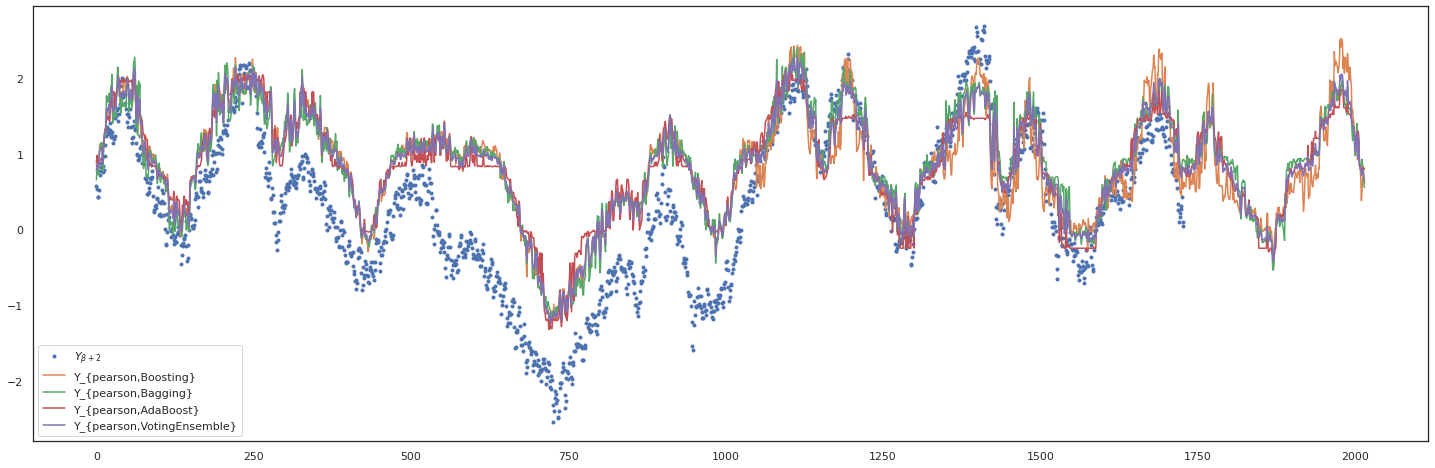

euclidian Boosting
euclidian Bagging
euclidian AdaBoost
euclidian VotingEnsemble


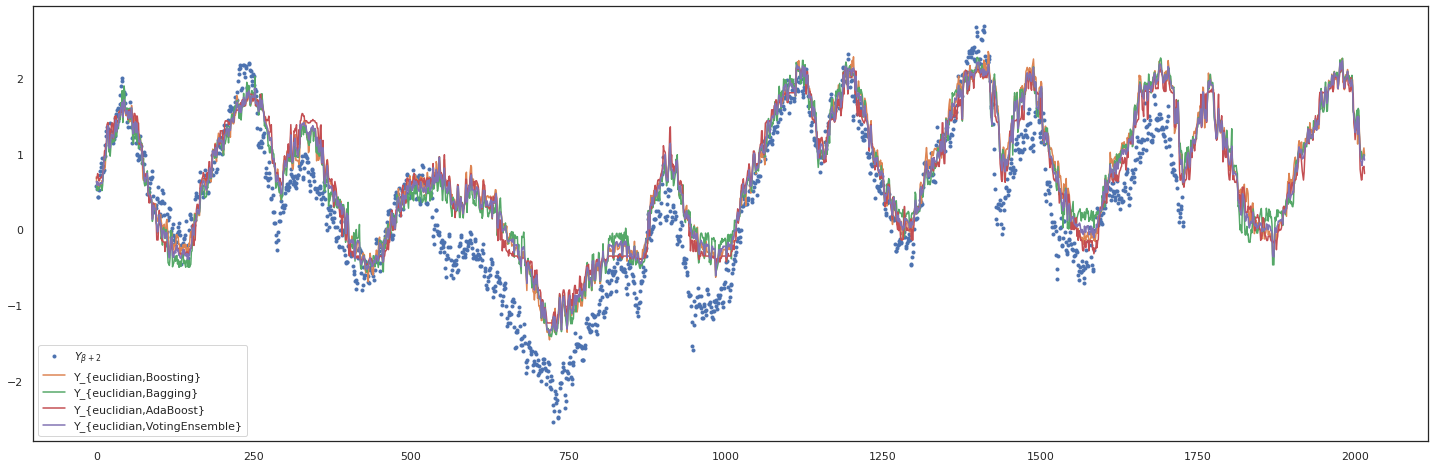

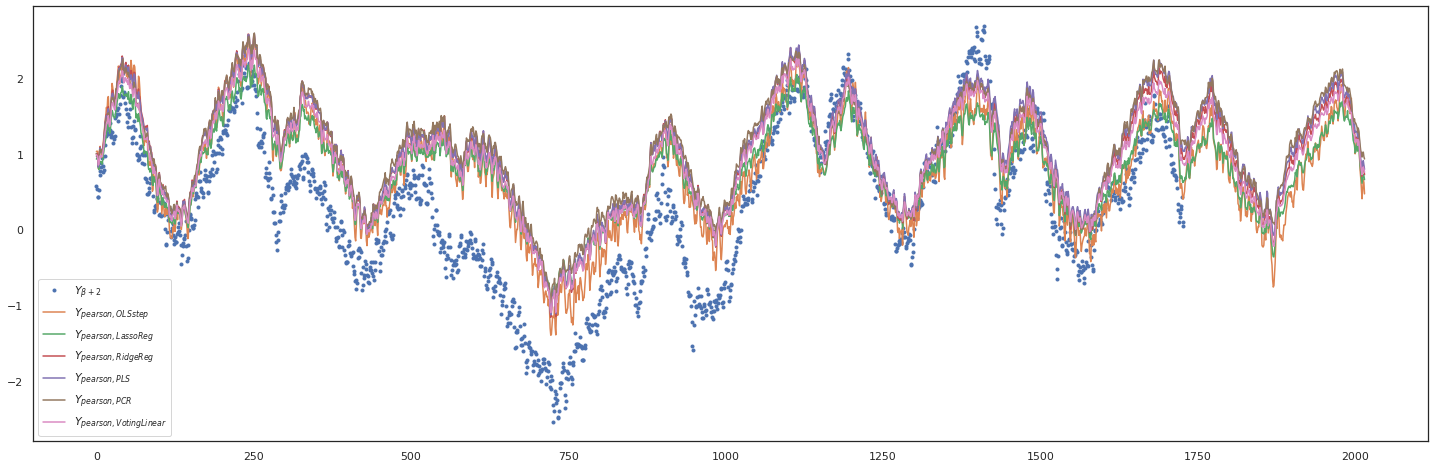

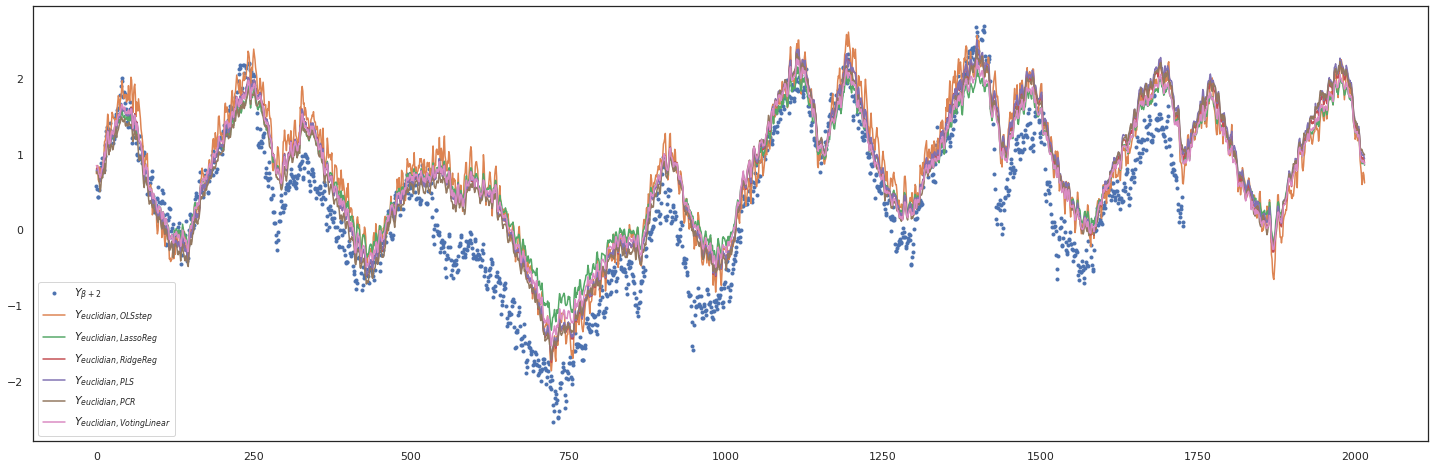

In [56]:
sel1 = ['R', 'Boosting', 'Bagging', 'AdaBoost', 'VotingEnsemble']
sel2 = ['OLSstep', 'LassoReg', 'RidgeReg', 'PLS', 'PCR', 'VotingLinear']

# cmap para colores distintos para cada distancia-método

for d in distances:
  plt.figure(figsize=(25,8))
  plt.plot(y_test, '.', label= '$Y_{\\beta+2}$')
  for r in preds.iterrows():
    values = r[1]
    if values.distance == d and values.method in sel1:
      print(values.distance, values.method)
      plt.plot(values.y_cap, label = 'Y_{' + values.distance + ',' + values.method + '}')
  plt.legend()
  plt.show()

for d in distances:
  plt.figure(figsize=(25,8))
  plt.plot(y_test, '.', label= '$Y_{\\beta+2}$')
  for r in preds.iterrows():
    values = r[1]
    if values.distance == d and values.method in sel2:
      plt.plot(values.y_cap, label = '$Y_{' + values.distance + ',' + values.method + '}$')
  plt.legend()
  plt.show()

### Ligas interesantes

[sklearn.ensemble: Ensemble Methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

[Ensemble methods sklearn](https://scikit-learn.org/0.16/modules/ensemble.html)

[Growing and Pruning Ensembles in Python](https://machinelearningmastery.com/growing-and-pruning-ensembles-in-python/)

[sklearn.feature_selection.RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)

[link texHow to Develop a Random Forest Ensemble in Python](https://machinelearningmastery.com/random-forest-ensemble-in-python/)